0. Imports and data loading

In [1]:
import IPython
from IPython.display import HTML, display, Image

from scipy import stats
import statsmodels.stats.diagnostic
import statsmodels.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import joblib
from itertools import repeat
from functools import partial
from collections import defaultdict, Counter

import scipy
from scipy.stats import kendalltau, spearmanr

from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

from google.colab import drive
drive.mount('/content/gdrive/')

path_to_files = '/content/gdrive/My Drive/_made/advanced_ml/hw2/data/'
# os.listdir(path_to_files)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl).
- тренировочный набор — турниры с dateStart из 2019 года
- тестовый — турниры с dateStart из 2020 года

In [ ]:
%%time 

tournaments = joblib.load(path_to_files + 'tournaments.pkl')

train_tournaments = {}
test_tournaments = {}

for k, v in tournaments.items():
    try:
        if v['dateStart'][:4] == '2019':
            train_tournaments[k] = v
        elif v['dateStart'][:4] == '2020':
            test_tournaments[k] = v
    except:
        pass

print(len(train_tournaments), len(test_tournaments))

687 418
CPU times: user 669 ms, sys: 43.4 ms, total: 712 ms
Wall time: 1.1 s


### Посмотрим на то, какую информацию можно извлечь из турниров

In [ ]:
tournament_types = defaultdict(int)
no_type_cnt = 0
id_types = set()
quantites = defaultdict(lambda: Counter())
for trt in train_tournaments.values():
    id_types.add(type(trt['id']))
    for k, v in trt['questionQty'].items():
        quantites[k][v] += 1

    t_type = trt.get('type')
    if t_type:
        tournament_types[t_type['name']] += 1
    else:
        no_type_cnt += 1

print(tournament_types, no_type_cnt, id_types)
print(quantites)

test_tournament_types = defaultdict(int)
no_type_cnt = 0
id_types = set()
quantites = defaultdict(lambda: Counter())
for trt in test_tournaments.values():
    id_types.add(type(trt['id']))
    for k, v in trt['questionQty'].items():
        quantites[k][v] += 1

    t_type = trt.get('type')
    if t_type:
        test_tournament_types[t_type['name']] += 1
    else:
        no_type_cnt += 1

print(test_tournament_types, no_type_cnt, id_types)
print(quantites)

defaultdict(<class 'int'>, {'Синхрон': 366, 'Асинхрон': 56, 'Обычный': 250, 'Строго синхронный': 6, 'Общий зачёт': 9}) 0 {<class 'int'>}
defaultdict(<function <lambda> at 0x7f663d2458c0>, {'1': Counter({12: 439, 15: 149, 13: 29, 18: 27, 10: 14, 14: 8, 36: 8, 9: 5, 8: 3, 11: 2, 100: 1, 45: 1, 23: 1}), '2': Counter({12: 439, 15: 149, 13: 29, 18: 27, 10: 14, 14: 8, 9: 5, 36: 5, 45: 4, 8: 3, 11: 2, 100: 1}), '3': Counter({12: 439, 15: 136, 13: 30, 10: 14, 14: 7, 9: 5, 36: 5, 45: 4, 8: 3, 18: 2, 11: 2, 100: 1}), '4': Counter({15: 74, 12: 73, 10: 11, 36: 6, 9: 5, 8: 3, 18: 2, 11: 2, 13: 1, 100: 1, 45: 1}), '5': Counter({15: 53, 12: 45, 36: 5, 10: 3, 9: 3, 8: 3, 11: 1, 16: 1, 13: 1, 14: 1, 100: 1, 45: 1}), '6': Counter({12: 32, 15: 32, 36: 5, 10: 3, 14: 2, 16: 1, 13: 1, 9: 1, 8: 1, 45: 1}), '7': Counter({12: 7, 15: 5, 14: 2, 10: 1, 9: 1, 13: 1, 8: 1, 36: 1}), '8': Counter({12: 7, 15: 5, 9: 1, 13: 1}), '9': Counter({12: 7, 15: 5, 9: 1, 13: 1}), '10': Counter({12: 6, 15: 5, 9: 1}), '11': Counte

#### есть какие-то совсем странные истории с категориями вопросов - по 25 за 1 турнир? (хотя написано, что марафон..)

In [ ]:
for trt in train_tournaments.values():
    for k, v in trt['questionQty'].items():
        if k == '25':
            break
    else:
        continue
    break
trt

{'dateEnd': '2019-12-22T15:30:00+03:00',
 'dateStart': '2019-12-21T15:30:00+03:00',
 'id': 6090,
 'name': 'Дзержинский марафон',
 'orgcommittee': [{'id': 7551,
   'name': 'Алексей',
   'patronymic': 'Александрович',
   'surname': 'Гончаров'},
  {'id': 14452,
   'name': 'Олег',
   'patronymic': 'Иванович',
   'surname': 'Климович'},
  {'id': 14457,
   'name': 'Татьяна',
   'patronymic': 'Григорьевна',
   'surname': 'Климович'},
  {'id': 19510,
   'name': 'Павел',
   'patronymic': 'Андреевич',
   'surname': 'Малецкий'}],
 'questionQty': {'1': 15,
  '10': 15,
  '11': 15,
  '12': 15,
  '13': 15,
  '14': 15,
  '15': 15,
  '16': 15,
  '17': 15,
  '18': 15,
  '19': 15,
  '2': 15,
  '20': 15,
  '21': 15,
  '22': 15,
  '23': 15,
  '24': 15,
  '25': 15,
  '26': 15,
  '27': 15,
  '28': 15,
  '29': 11,
  '3': 15,
  '4': 15,
  '5': 15,
  '6': 15,
  '7': 15,
  '8': 15,
  '9': 15},
 'season': '/seasons/53',
 'synchData': None,
 'type': {'id': 2, 'name': 'Обычный'}}

In [ ]:
questions_distribution = [sum(trt['questionQty'].values()) for trt in train_tournaments.values()]
print(min(questions_distribution), max(questions_distribution), np.mean(questions_distribution), np.median(questions_distribution))
questions_distribution = [sum(trt['questionQty'].values()) for trt in test_tournaments.values()]
print(min(questions_distribution), max(questions_distribution), np.mean(questions_distribution), np.median(questions_distribution))

23 500 49.620087336244545 36.0
3 330 43.557416267942585 36.0


### соберём данные в записи формата - игрок - турнир - результат

In [ ]:
%%time
results = joblib.load(path_to_files + 'results.pkl')
print(len(results))

CPU times: user 2min 47s, sys: 7.26 s, total: 2min 54s
Wall time: 2min 54s


In [ ]:
len(results[6069][0])

9

In [ ]:
results[6069][3]

In [ ]:
def get_tournament_length(t):
    if t['questionQty']:
        return sum(t['questionQty'].values())
    return 0

def validate_mask(mask):
    if mask:
        if 'X' in mask or '?' in mask:
            return False
        return True
    return False

def get_mask_ratios(mask):
    """ 
    returns total ratio and ratios in first and last part
    """
    total_ratio = mask.count('1') / len(mask)
    L = len(mask)
    if L < 10:
        return total_ratio, total_ratio, total_ratio
    halfway = L // 2 + 1
    return total_ratio, mask[:halfway].count('1') / (halfway), mask[halfway:].count('1') / (L - halfway)

def get_player_name(p):
    return ' '.join((p.get("surname", ""), p.get("name", ""), p.get("patronymic", "")))

In [ ]:
tournament_results

In [ ]:
selected_results = list()[4500:4510]

In [ ]:
[(sr[0], sr[0] in train_tournaments, sr[0] in test_tournaments) for sr in selected_results]

[(5363, True, False),
 (5364, True, False),
 (5365, False, False),
 (5366, True, False),
 (5367, True, False),
 (5368, True, False),
 (5369, True, False),
 (5370, True, False),
 (5371, True, False),
 (5372, True, False)]

In [ ]:
train_records = []
test_records = []
broken_tournaments = 0

for tournament_id, tournament_results in tqdm(results.items()):
    if tournament_id in train_tournaments:
        queue = train_records
        tournament = train_tournaments[tournament_id]
    elif tournament_id in test_tournaments:
        queue = test_records
        tournament = test_tournaments[tournament_id]
    else:
        continue

    n_questions = get_tournament_length(tournament)
    tournament_type = tournament.get('type')
    if tournament_type:
        tournament_type = tournament_type.get('name')

    for team_results in tournament_results:
        team_position = int(team_results.get('position', -1))
        team = team_results.get('team')
        if not team:
            continue
        team_id = team.get('id', -888)
        team_name = team.get('name', 'NO_TEAM_NAME')
        mask = team_results.get("mask")
        team_record = (tournament_id, tournament_type, team_id, team_name, team_position, n_questions, mask)
        if not validate_mask(mask) or len(mask) != n_questions:
            # print(f'team record is corrupted or do not match tournaments info: {team_record}')
            broken_tournaments += 1
            continue
        correct_ratio = get_mask_ratios(mask)
        for player in team_results["teamMembers"]:
            player_params = player.get('player')
            if player_params:
                player_id = player_params.get('id', -888)
                player_name = get_player_name(player_params)
                queue.append(team_record + (player_id, player_name) + correct_ratio)

print(len(train_records), len(test_records), broken_tournaments)


349825 95186 23113


In [ ]:
train_records = pd.DataFrame(train_records, columns = ['tournament_id', 'tournament_type', 'team_id', 'team_name', 'team_position', 'n_questions', 'mask', 'player_id', 'player_name', 'ratio', 'ratio_start', 'ratio_end'])
test_records = pd.DataFrame(test_records, columns = ['tournament_id', 'tournament_type', 'team_id', 'team_name', 'team_position', 'n_questions', 'mask', 'player_id', 'player_name', 'ratio', 'ratio_start', 'ratio_end'])

display(train_records.head())
display(test_records.head())

,tournament_id,tournament_type,team_id,team_name,team_position,n_questions,mask,player_id,player_name,ratio,ratio_start,ratio_end
0,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,6212,Выменец Юрий Яковлевич,0.777778,0.894737,0.647059
1,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,18332,Либер Александр Витальевич,0.777778,0.894737,0.647059
2,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,18036,Левандовский Михаил Ильич,0.777778,0.894737,0.647059
3,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,22799,Николенко Сергей Игоревич,0.777778,0.894737,0.647059
4,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,15456,Коновалов Сергей Владимирович,0.777778,0.894737,0.647059


,tournament_id,tournament_type,team_id,team_name,team_position,n_questions,mask,player_id,player_name,ratio,ratio_start,ratio_end
0,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,18490,Литвинов Дмитрий Сергеевич,0.916667,1.0,0.823529
1,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,116901,Шевцова Екатерина Сергеевна,0.916667,1.0,0.823529
2,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,8532,Гурт Евгений Викторович,0.916667,1.0,0.823529
3,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,42346,Романцова Богдана Михайловна,0.916667,1.0,0.823529
4,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,123190,Красникова Елена Александровна,0.916667,1.0,0.823529


In [ ]:
train_records[['player_id']].drop_duplicates().shape,\
test_records[['player_id']].drop_duplicates().shape,\
pd.merge(test_records[['player_id']].drop_duplicates(), train_records[['player_id']].drop_duplicates()).shape

((55624, 1), (28109, 1), (22169, 1))

#### то есть ~6к игроков впервые встречаются на тестовом сете

In [ ]:
test_records['new_player'] = 1 - test_records['player_id'].isin(set(train_records['player_id'])).astype(int)
display(test_records.head())

,tournament_id,tournament_type,team_id,team_name,team_position,n_questions,mask,player_id,player_name,ratio,ratio_start,ratio_end,new_player
0,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,18490,Литвинов Дмитрий Сергеевич,0.916667,1.0,0.823529,0
1,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,116901,Шевцова Екатерина Сергеевна,0.916667,1.0,0.823529,0
2,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,8532,Гурт Евгений Викторович,0.916667,1.0,0.823529,0
3,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,42346,Романцова Богдана Михайловна,0.916667,1.0,0.823529,0
4,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,123190,Красникова Елена Александровна,0.916667,1.0,0.823529,0


In [ ]:
train_records.to_csv(path_to_files + 'train_records.csv', index = False)
test_records.to_csv(path_to_files + 'test_records.csv', index = False)

### loading data

In [2]:
%%time 

train_records = pd.read_csv(path_to_files + 'train_records.csv')
test_records = pd.read_csv(path_to_files + 'test_records.csv')

train_players = set(train_records['player_id'])
test_players = set(test_records['player_id'])
new_test_players = test_players.difference(train_players)
old_test_players = test_players.intersection(train_players)

print(len(train_players), len(test_players), len(old_test_players), len(new_test_players))

display(train_records.head())
display(test_records.head())

55624 28109 22169 5940


,tournament_id,tournament_type,team_id,team_name,team_position,n_questions,mask,player_id,player_name,ratio,ratio_start,ratio_end
0,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,6212,Выменец Юрий Яковлевич,0.777778,0.894737,0.647059
1,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,18332,Либер Александр Витальевич,0.777778,0.894737,0.647059
2,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,18036,Левандовский Михаил Ильич,0.777778,0.894737,0.647059
3,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,22799,Николенко Сергей Игоревич,0.777778,0.894737,0.647059
4,4772,Синхрон,45556,Рабочее название,1,36,111111111011111110111111111100010010,15456,Коновалов Сергей Владимирович,0.777778,0.894737,0.647059


,tournament_id,tournament_type,team_id,team_name,team_position,n_questions,mask,player_id,player_name,ratio,ratio_start,ratio_end,new_player
0,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,18490,Литвинов Дмитрий Сергеевич,0.916667,1.0,0.823529,0
1,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,116901,Шевцова Екатерина Сергеевна,0.916667,1.0,0.823529,0
2,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,8532,Гурт Евгений Викторович,0.916667,1.0,0.823529,0
3,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,42346,Романцова Богдана Михайловна,0.916667,1.0,0.823529,0
4,5414,Синхрон,66120,Чатик,1,36,111111111111111111111110111110101111,123190,Красникова Елена Александровна,0.916667,1.0,0.823529,0


CPU times: user 1.06 s, sys: 106 ms, total: 1.17 s
Wall time: 2.79 s


Разнесём ответы на каждый из вопросов в турнире для каждого игрока

In [7]:
%%time 

train_questions_records = []

for row in tqdm(train_records.itertuples()):
    tournament_id, tournament_type, team_id, team_name, team_position, n_questions, mask, player_id, player_name, ratio, ratio_start, ratio_end = row[1:]
    for i, answer in enumerate(mask):
        train_questions_records.append((tournament_id, tournament_type, team_id, player_id, n_questions, i, int(answer)))

print(len(train_questions_records))

train_questions_records = pd.DataFrame(train_questions_records, columns = ['tournament_id', 'tournament_type', 'team_id', 'player_id', 'n_questions', 'question_index', 'y'])


14678548
CPU times: user 31.7 s, sys: 3.8 s, total: 35.5 s
Wall time: 35.4 s


In [8]:
display(train_questions_records.head(3))
display(train_questions_records.tail(3))

,tournament_id,tournament_type,team_id,player_id,n_questions,question_index,y
0,4772,Синхрон,45556,6212,36,0,1
1,4772,Синхрон,45556,6212,36,1,1
2,4772,Синхрон,45556,6212,36,2,1


,tournament_id,tournament_type,team_id,player_id,n_questions,question_index,y
14678545,6254,Общий зачёт,74229,208188,216,213,0
14678546,6254,Общий зачёт,74229,208188,216,214,0
14678547,6254,Общий зачёт,74229,208188,216,215,0


In [9]:
def get_question_complexity(df, player_level = True):
    """
    функция генерирует сложность вопроса как "1 - доля игроков/команд, ответивших на него верно"
    здесь может быть некоторый лик, если считать с учётом команды, для которой рассчитывается фактор
    например, если все команды ответили верно, то доля равна 1 и очевидно таргет для наблюдения также равен 1
    если исключать команду, то получается некоторый аналог target-encoding по фолдам (конкретно здесь leave-one-out)
    по идее, если сложность вопроса высокая, но у команды таргет 1, то это должно увеличивать вес one-hot-фактора игрока для каждого из игроков в команде
    """

    ### сколько всего людей отвечало на вопрос/ответило верно/сколько всего команд отвечало на вопрос
    answers_question_count = df.groupby(['tournament_id', 'question_index']).agg({
        'player_id': 'nunique',  'y':'sum', 'team_id': 'nunique',
        }).reset_index().rename({
        'player_id':'players_total_answers', 'y':'players_correct_answers', 'team_id':'teams_total_answers'
        }, axis = 1)
        
    # ### сколько всего человек в каждой команде
    team_player_count = df.groupby(['tournament_id', 'team_id']).agg({'player_id': 'nunique'}).reset_index().rename({'player_id':'team_players_total'}, axis = 1)
    if player_level:
        df1 = pd.merge(pd.merge(df, answers_question_count, on = ['tournament_id', 'question_index']), team_player_count, on = ['tournament_id', 'team_id'])
        df1['question_complexity'] = 1 - (df1['players_correct_answers'] - (df1['y'] * df1['team_players_total'])) / (df1['players_total_answers'] - df1['team_players_total'])
        return df1['question_complexity']

    # ### ответ команды на вопрос
    team_question_answer = df.groupby(['tournament_id', 'question_index', 'team_id']).agg({'y': 'max'}).reset_index().rename({'y':'team_answer'}, axis = 1)
    # ### cколько команд ответило верно
    question_answer_team_count = team_question_answer.groupby(['tournament_id', 'question_index']).agg({'team_answer':'sum'}).reset_index().rename({'team_answer':'teams_correct_answers'}, axis = 1)
    del team_question_answer
    df2 = pd.merge(pd.merge(pd.merge(df,
                                     answers_question_count, on = ['tournament_id', 'question_index']),
                            team_player_count, on = ['tournament_id', 'team_id']),
                   question_answer_team_count, on = ['tournament_id', 'question_index'])
    df2['question_complexity'] = 1 - (df2['teams_correct_answers'] - (df2['y'] * 1)) / (df2['teams_total_answers'] - 1)
    return df2['question_complexity']


In [10]:
train_questions_records['players_question_complexity'] = get_question_complexity(train_questions_records, player_level = True)
train_questions_records['teams_question_complexity'] = get_question_complexity(train_questions_records, player_level = False)

In [11]:
spearmanr(train_questions_records['players_question_complexity'], train_questions_records['teams_question_complexity'])

SpearmanrResult(correlation=nan, pvalue=nan)

In [12]:
train_questions_records['players_question_complexity'].isna().sum(), train_questions_records['teams_question_complexity'].isna().sum(), 

(252, 252)

In [13]:
#### в некоторых турнирах было по одной команде..?
train_questions_records[train_questions_records['players_question_complexity'].isna()].groupby(['tournament_id']).agg({'team_id':'nunique'})

,team_id
tournament_id,
5876,1
6102,1


In [14]:
#### странно, что корреляция такая низкая
spearmanr(train_questions_records['players_question_complexity'].dropna(), train_questions_records['teams_question_complexity'].dropna())

SpearmanrResult(correlation=0.13265913271298094, pvalue=0.0)

In [15]:
pqc_min, pqc_mean, pqc_max = [f(x) for f, x in zip((np.nanmin,np.nanmean,np.nanmax), repeat(train_questions_records['players_question_complexity']))]
print(pqc_min, pqc_mean, pqc_max)

tqc_min, tqc_mean, tqc_max = [f(x) for f, x in zip((np.nanmin,np.nanmean,np.nanmax), repeat(train_questions_records['teams_question_complexity']))]
print(tqc_min, tqc_mean, tqc_max)

train_questions_records['players_question_complexity'] = train_questions_records['players_question_complexity'].fillna(pqc_mean)
train_questions_records['teams_question_complexity'] = train_questions_records['teams_question_complexity'].fillna(tqc_mean)

0.0 0.5678659483437233 1.0
0.0 0.5754650824184429 1.0


In [61]:
train_questions_records.to_csv(path_to_files + 'train_questions_records.csv', index = False)

In [3]:
%%time 
train_questions_records = pd.read_csv(path_to_files + 'train_questions_records.csv')
train_questions_records.head(3)

CPU times: user 9.16 s, sys: 1.39 s, total: 10.5 s
Wall time: 32.7 s


### кодируем игроков и типы турниров

In [4]:
%%time 

player_ohe = OneHotEncoder()
player_ohe.fit(train_questions_records[['player_id']])
tour_type_ohe = OneHotEncoder()
tour_type_ohe.fit(train_questions_records[['tournament_type']])
tour_ohe = OneHotEncoder()
tour_ohe.fit(train_questions_records[['tournament_id']])

CPU times: user 1.51 s, sys: 9.36 ms, total: 1.52 s
Wall time: 1.52 s


In [5]:
def get_features(df, player = True, tournament = True, tournament_type = True, question = True):
    features = []
    features.append(player_ohe.transform(df[['player_id']]))
    if tournament:
        features.append(tour_ohe.transform(df[['tournament_id']]))
    if tournament_type:
        features.append(tour_type_ohe.transform(df[['tournament_type']]))
    if question:
        features.append(scipy.sparse.csr.csr_matrix(df[['players_question_complexity', 'teams_question_complexity']]))
    return scipy.sparse.hstack(features)

# get_features_test = partial(get_features, question = False)
def get_features_test(df, player = True, tournament = True, tournament_type = True, question = True, pqc = 0.5678659483437233, tqc = 0.5754650824184429):
    features = []
    features.append(player_ohe.transform(df[['player_id']]))
    if tournament:
        features.append(scipy.sparse.csr.csr_matrix(np.zeros((len(df), len(tour_ohe.get_feature_names())))))
    if tournament_type:
        features.append(tour_type_ohe.transform(df[['tournament_type']]))
    if question:
        features.append(scipy.sparse.csr.csr_matrix(np.vstack([np.ones(len(df)) * pqc, np.ones(len(df)) * tqc]).T))
    return scipy.sparse.hstack(features)

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score

In [7]:
!nvidia-smi

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

Sat Apr 10 17:27:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### torch LogisticRegression module

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.fc(x))
    

def plot_train_process(train_loss, train_accuracy, val_loss = None, val_accuracy = None, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    if val_loss:
        axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    if val_accuracy:
        axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def train_model(model, X, y, optimizer, n_iterations = 10, device = 'cpu', clip = 1, eval_every = 1, batch_size = None, show_plots = True):
    
    loss_function = nn.BCELoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    train_loss_history, train_acc_history = [], []

    #### попробуем поучить без разбивки по батчам
    if not batch_size:
        pass
        # batch_size = len(y)
        # dataloader = ((X, y))
    else:
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    for i in tqdm(range(n_iterations)):
        if not batch_size: 
            X_batch, y_batch = X, y
            optimizer.zero_grad()
            sigmoid_logits = model(X_batch)
            loss = loss_function(sigmoid_logits, y_batch)
            loss.backward()
            ### clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()            
        else:
            for X_batch, y_batch in dataloader: 
                optimizer.zero_grad()
                sigmoid_logits = model(X_batch)
                loss = loss_function(sigmoid_logits, y_batch)
                loss.backward()
                ### clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()

        if i % eval_every == 0:
            with torch.no_grad():
                if not batch_size:
                    sigmoid_logits = model(X)
                    loss = loss_function(sigmoid_logits, y)
                train_loss_history.append(loss)
                acc = accuracy_score(y.cpu().numpy(), (sigmoid_logits.cpu().detach().numpy() > 0.5).astype(int))
                train_acc_history.append(acc)
                # lr_scheduler.step(train_loss_history[-1])

                if show_plots:
                    IPython.display.clear_output(wait=True)
                    plot_train_process(train_loss_history, train_acc_history)
            torch.cuda.empty_cache()

### генерируем спарс-матрицу факторов

In [9]:
%%time 

X_fit = get_features(train_questions_records, tournament = True, tournament_type = True, question = True)
y_fit = train_questions_records['y']

X_fit_torch = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((X_fit.tocoo().row, X_fit.tocoo().col))), #### pairs of indices
    torch.FloatTensor(X_fit.tocoo().data), #### values for pairs of indices
)

y_fit_torch = torch.FloatTensor(y_fit.values).reshape(-1, 1)

X_fit_torch.shape, y_fit_torch.shape

CPU times: user 7.78 s, sys: 574 ms, total: 8.35 s
Wall time: 8.46 s


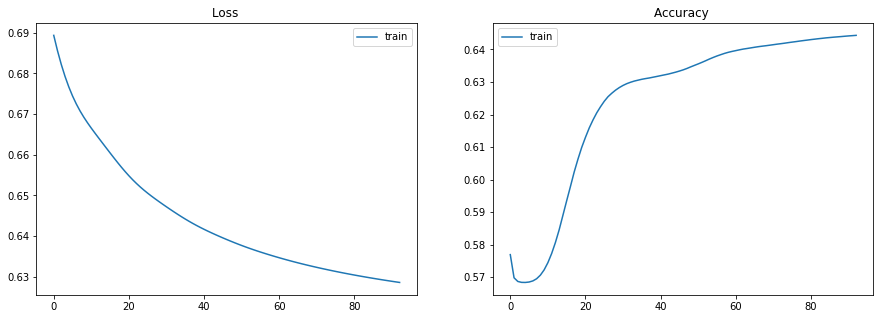

RuntimeError: ignored

In [11]:
input_dim = X_fit_torch.shape[1]
model = LogisticRegression(input_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2)

train_model(model, X_fit_torch, y_fit_torch, optimizer,
            device=DEVICE,
            clip = 0.5,
            batch_size = None,
            # batch_size = int(1e6),
            n_iterations = 200)

In [12]:
all_f_model = model.cpu()

3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров.

Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь
неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд
- в качестве метрики качества на тестовом наборе давайте считать ранговые
корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между
реальным ранжированием в результатах турнира и предсказанным моделью,
усреднённые по тестовому множеству турниров


Силу команды $i$ на вопросе $j$ можно определять множеством способов, например:
- максимальная вероятность ответа на вопрос
- средняя вероятность ответа на вопрос
- вероятность того, что хотя бы один из игроков отвечает верно,
т.е. $1 - \prod_{k = 1}^{N}(1 - p_{kj})$

Выше $p_{kj} = \sigma(s_k + qc_j + \overline{shift})$,  где $s_k$ - сила игрока по обученной модели, $qc_j$ - сложность вопроса, $\overline{shift}$ - константа регрессии

Соответственно, на турнир расчёт можно перенести, подставляя среднюю сложность вопроса для всех игроков

Общий рейтинг на тестовых данных можно получить собрав всех игроков со всех турниров в один пул и подставив всем общую сложность для одного вопроса

Поскольку модель линейная, то не имеет значения, какую сложность вопроса подставлять - изменится только абсолютное значение вероятности, но не ранжировка

In [27]:
def calc_test_correlations(test_records, model):
    known_players = test_records.query('new_player == 0').copy()
    unknown_players = test_records.query('new_player == 1').copy()
    X_known = get_features_test(known_players)
    X_known_torch = torch.sparse.FloatTensor(
        torch.LongTensor(np.vstack((X_known.tocoo().row, X_known.tocoo().col))), #### pairs of indices
        torch.FloatTensor(X_known.tocoo().data), #### values for pairs of indices
    )

    with torch.no_grad():
        known_proba = all_f_model(X_known_torch).cpu().numpy().flatten()
    known_players['proba'] = known_proba
    avg_proba = known_proba.mean()
    avg_proba_by_tour_type = known_players.groupby('tournament_type').agg({'proba':'mean'}).to_dict()['proba']
    unknown_players['proba'] = unknown_players['tournament_type'].replace(avg_proba_by_tour_type)
    # unknown_players['proba'] = avg_proba
    unknown_players['proba'] = unknown_players['proba'].astype(float)
    all_players = pd.concat([unknown_players, known_players], axis = 0, ignore_index = True)
    all_players['proba'] = all_players['proba'].astype(float)
    
    agg_prod = lambda x: 1 - np.prod(1 - x)
    agg_max = lambda x: max(x)
    agg_mean = lambda x: np.mean(x)

    for agg_func in (agg_prod, agg_max, agg_mean):

        all_tours_teams = all_players.groupby(["tournament_id", "team_id"]).agg({"proba" : agg_func, "team_position" : 'max'}).reset_index()

        spearman_corr = all_tours_teams.groupby("tournament_id").apply(lambda x: spearmanr(-x['proba'], x['team_position'])[0]).mean()
        kendall_corr = all_tours_teams.groupby("tournament_id").apply(lambda x: kendalltau(-x['proba'], x['team_position'])[0]).mean()
        print(spearman_corr, kendall_corr)

In [28]:
calc_test_correlations(test_records, all_f_model)

0.6124287616297366 0.46968652214798373
0.6435749387871416 0.4968055619489724
0.6607708203130335 0.513455103705231


In [35]:
def top_players(test_records, model, top = 20):
    known_players = test_records.query('new_player == 0').copy()
    known_players['tournament_type'] = 'Синхрон'
    unknown_players = test_records.query('new_player == 1').copy()
    X_known = get_features_test(known_players)
    X_known_torch = torch.sparse.FloatTensor(
        torch.LongTensor(np.vstack((X_known.tocoo().row, X_known.tocoo().col))), #### pairs of indices
        torch.FloatTensor(X_known.tocoo().data), #### values for pairs of indices
    )

    with torch.no_grad():
        known_proba = all_f_model(X_known_torch).cpu().numpy().flatten()
    known_players['proba'] = known_proba
    avg_proba = known_proba.mean()
    avg_proba_by_tour_type = known_players.groupby('tournament_type').agg({'proba':'mean'}).to_dict()['proba']
    # unknown_players['proba'] = unknown_players['tournament_type'].replace(avg_proba_by_tour_type)
    # unknown_players['proba'] = unknown_players['proba'].astype(float)
    unknown_players['proba'] = avg_proba

    all_players = pd.concat([unknown_players, known_players], axis = 0, ignore_index = True)
    all_players['proba'] = all_players['proba'].astype(float)
    # display(all_players)
    return all_players.groupby('player_id').agg({'proba':'mean', 'player_name':'min'}).sort_values(by = 'proba', ascending = False).iloc[:top,:]

In [36]:
xxx = top_players(test_records, all_f_model, top = 20)
xxx

,proba,player_name
player_id,,
22474,0.610380,Немец Илья Сергеевич
707,0.610139,Александрова Елена Андреевна
176888,0.609484,Штокман Михаил Олегович
27622,0.606247,Рябых Николай Георгиевич
38196,0.605775,Митрофанов Артём Александрович
74001,0.604017,Мокин Игорь Викторович
222188,0.603929,Гринко Арина
13689,0.602910,Карякин Дмитрий Александрович
22530,0.602718,Федякова Екатерина Сергеевна


4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько
игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать
упрощающие предположения, но теперь переменные “игрок X ответил на вопрос
Y” при условии данных должны стать зависимыми для игроков одной и той же
команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем
растут (скорее всего, ненамного, но расти должны), выберите лучшую модель,
используя целевые метрики.


В данных мы видим только ответы команды, но не факт, что каждый игрок ответил бы правильно, если команда ответила правильно

В обратную сторону для простоты считаем, что выполняется условие - если ни один игрок не знает ответа, то у команды на вопрос ответ также 0

Тогда эта задача по сути presense-only data, только absense-only :)

Пусть ответ команды $i$ на вопрос $j$ есть $t_{ij}$

Вводя скрытые переменные $z_{kj}$ для каждой пары игрок-вопрос будем иметь, что

${p(t_{ij} = 1|max(z_{kj}) = 1) = 1}$

EM-алгоритм будет выглядеть так, что на E-шаге мы будем находить МО для скрытых переменных
${p(z_{kj} = 1|t_{ij} = y)}$ по всем соответствующим $i,j,k$


Но из условия в обратную сторону будем считать, что
${p(z_{kj} = 1|t_{ij} = 0) = 0}$

Тогда для неверных ответов лейблы изменяться не будут, а для остальных будем корректировать лейблы при помощи корректировки вероятностью ответа всей командой, полученных с прогноза M-шага

${p(z_{kj} = 1|t_{ij} = 1) = \frac{p(t_{ij} = 1|z_{kj} = 1)p(z_{kj} = 1)}{p(t_{ij} = 1)}} = \frac{1 * p(z_{kj} = 1)}{p(t_{ij} = 1)} = \frac{1 * p_{kj}}{1 - \prod_{k}(1 - p_{kj})}$

На M-шаге обучаем веса регрессии на скорректированных лейблах

In [ ]:
def E_step(model, train_data, X, y):
    with torch.no_grad():
        predictions = model(X).cpu().numpy().flatten()
    train_data.loc[train_data['y'] == 0, 'ind_y'] = 0